In [3]:
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [4]:
def get_normalized_data():
    df = pd.read_csv('../datasets/mnist/train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    Y = data[:,0]
    X = data[:,1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std==0, 1)
    X = (X-mu)/std
    return X, Y

def error_rate(p, t):
    return np.mean(p != t)

In [5]:
class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W = np.random.randn(M1, M2) / np.sqrt(2.0 / M1)
        b = np.zeros(M2)
        self.W = theano.shared(W, 'W_%s'%self.id)
        self.b = theano.shared(b, 'b_%s'%self.id)
        self.params = [self.W, self.b]

    def forward(self, X):
        return T.nnet.relu(X.dot(self.W) + self.b)

In [8]:
class ANN(object):
    def __init__(self, hidden_layer_sizes, p_keep):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.dropout_rates = p_keep

    def fit(self, X, Y, learning_rate=1e-3, mu=0.9, decay=0.9, epochs=8, batch_sz=100, show_fig=False):
        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.int32)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]

        self.rng = RandomStreams()

        # initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W = np.random.randn(M1, K) / np.sqrt(M1)
        b = np.zeros(K)
        self.W = theano.shared(W, 'W_logreg')
        self.b = theano.shared(b, 'b_logreg')
        
        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # set up theano functions and variables
        thX = T.matrix('X')
        thY = T.ivector('Y')
        pY_train = self.forward_train(thX)

        # this cost is for training
        cost = -T.mean(T.log(pY_train[T.arange(thY.shape[0]), thY]))

        # gradients wrt each param
        grads = T.grad(cost, self.params)

        # for momentum
        dparams = [theano.shared(np.zeros_like(p.get_value())) for p in self.params]

        # for rmsprop
        cache = [theano.shared(np.ones_like(p.get_value())) for p in self.params]

        new_cache = [decay*c + (1-decay)*g*g for p, c, g in zip(self.params, cache, grads)]
        new_dparams = [mu*dp - learning_rate*g/T.sqrt(new_c + 1e-10) for p, new_c, dp, g in zip(self.params, new_cache, dparams, grads)]
        updates = [
            (c, new_c) for c, new_c in zip(cache, new_cache)
        ] + [
            (dp, new_dp) for dp, new_dp in zip(dparams, new_dparams)
        ] + [
            (p, p + new_dp) for p, new_dp in zip(self.params, new_dparams)
        ]

        # momentum only
        # updates = [
        #     (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, dparams)
        # ] + [
        #     (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, dparams)
        # ]

        train_op = theano.function(
            inputs=[thX, thY],
            updates=updates
        )

        # for evaluation and prediction
        pY_predict = self.forward_predict(thX)
        cost_predict = -T.mean(T.log(pY_predict[T.arange(thY.shape[0]), thY]))
        prediction = self.predict(thX)
        cost_predict_op = theano.function(inputs=[thX, thY], outputs=[cost_predict, prediction])

        n_batches = N // batch_sz
        costs = []
        for i in range(epochs):
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                train_op(Xbatch, Ybatch)

                if i % 2 == 0 and j==0:
                    c, p = cost_predict_op(Xvalid, Yvalid)
                    costs.append(c)
                    e = error_rate(Yvalid, p)
                    print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
                    #print("i: {},j: {}, nb: {}, cost: {:.5f}, error rate: {.5f}".format(i,j,n_batches, c, e))
        
        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward_train(self, X):
        Z = X
        for h, p in zip(self.hidden_layers, self.dropout_rates[:-1]):
            mask = self.rng.binomial(n=1, p=p, size=Z.shape)
            Z = mask * Z
            Z = h.forward(Z)
        mask = self.rng.binomial(n=1, p=self.dropout_rates[-1], size=Z.shape)
        Z = mask * Z
        return T.nnet.softmax(Z.dot(self.W) + self.b)
    
    def forward_predict(self, X):
        Z = X
        for h, p in zip(self.hidden_layers, self.dropout_rates[:-1]):
            Z = h.forward(p * Z)
        return T.nnet.softmax((self.dropout_rates[-1] * Z).dot(self.W) + self.b)

    def predict(self, X):
        pY = self.forward_predict(X)
        return T.argmax(pY, axis=1)

i: 0 j: 0 nb: 410 cost: 20166.093785054294 error rate: 0.853
i: 2 j: 0 nb: 410 cost: 2188.9675979827325 error rate: 0.189
i: 4 j: 0 nb: 410 cost: 1174.6548624705415 error rate: 0.158
i: 6 j: 0 nb: 410 cost: 786.3970004418782 error rate: 0.147


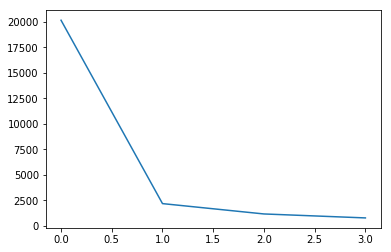

In [9]:
X, Y = get_normalized_data()

ann = ANN([500, 300], [0.8, 0.5, 0.5])
ann.fit(X, Y, show_fig=True)